# 1. Introduction

Name: Vincent

Batch: BSD_002

Problem statement:
The Look e-commerce management want to build(s) a warehouse in order to build an efficient warehousing system.

Objective:

I want to make a Clustering unsupervised model machine learning to know how many warehouse(s) should management build.

# 2. Import Libraries

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Auth')

Auth


In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project="hacktiv8-vincenttd-398106")

In [ ]:
!pip install -q geopandas

In [ ]:
# import library
import pandas as pd

# Import geopandas
import geopandas as gdp

# Import visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import feature scaling
from sklearn.preprocessing import MinMaxScaler

# Import model
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
# we use geopy to find excat location name for each center from coordinates
!pip install -q geopy
from geopy.geocoders import Nominatim

# 3. Data Loading

In [1]:
# load data
df_ori = client.query('''
select *
from `bigquery-public-data.thelook_ecommerce.users`
where country = 'United States'
and state <>'Hawaii'
''').to_dataframe()
df_ori

NameError: name 'client' is not defined

In [ ]:
# Duplicate data original
df = df_ori.copy()

In [ ]:
# Show df
df.head()

,id,first_name,last_name,email,age,gender,state,street_address,postal_code,city,country,latitude,longitude,traffic_source,created_at
0,4976,James,Farrell,jamesfarrell@example.org,41,M,Iowa,272 Bird Road Apt. 210,50010,Ames,United States,42.032948,-93.591097,Display,2022-10-11 06:47:00+00:00
1,21505,Joseph,Davis,josephdavis@example.org,61,M,Iowa,6305 Michael Drives Suite 106,50010,Ames,United States,42.032948,-93.591097,Organic,2022-06-13 05:14:00+00:00
2,50419,Dakota,Erickson,dakotaerickson@example.net,27,M,Iowa,0016 Jonathan Branch Suite 120,50010,Ames,United States,42.032948,-93.591097,Search,2020-07-03 00:32:00+00:00
3,65390,Julie,Ortega,julieortega@example.com,34,F,Iowa,05031 Karen Extensions,50010,Ames,United States,42.032948,-93.591097,Organic,2019-05-12 04:25:00+00:00
4,89456,Leslie,Ray,leslieray@example.net,48,F,Iowa,66629 Gregory Circle Apt. 431,50010,Ames,United States,42.032948,-93.591097,Search,2022-02-08 06:59:00+00:00


# 4. EDA

In [ ]:
# Define map for visualization
map = gdp.read_file('https://raw.githubusercontent.com/wri/wri-bounds/master/dist/all_countries.geojson')
map = map[map['name']=='United States of America']['geometry']
map

233    MULTIPOLYGON (((-155.60652 20.13796, -155.5863...
Name: geometry, dtype: geometry

(25.0, 50.0)

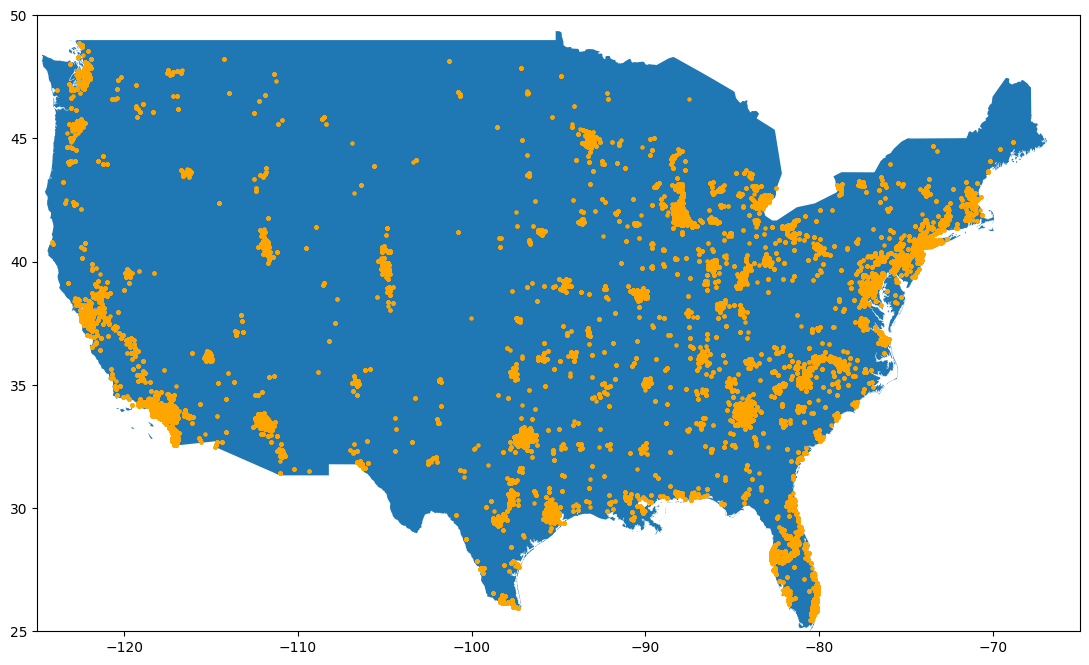

In [ ]:
# Visualize USA map and customer plotting
fig,ax = plt.subplots(figsize=(16,8))
map.plot(ax=ax)
ax.scatter(df['longitude'],df['latitude'],color='orange',s=5)
ax.set_xlim(-125,-65)
ax.set_ylim(25,50)

# 5. Preprocessing/Feature Engineering

In [ ]:
# Feature scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(df[['longitude','latitude']])

In [ ]:
# Find cluster using elbow method

inertias = []
sil_score = []
for k in range(2,21):
  km = KMeans(n_clusters=k).fit(X)
  inertias.append(km.inertia_)
  sil_score.append(silhouette_score(X,km.labels_))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Text(0, 0.5, 'Inertia')

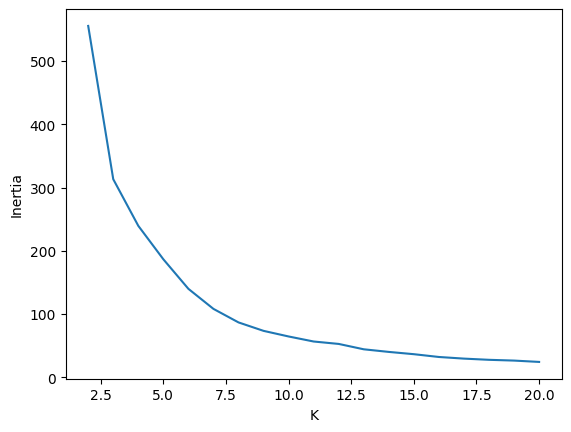

In [ ]:
# Visualize the elbow
plt.plot(range(2,21),inertias)
plt.xlabel('K')
plt.ylabel('Inertia')

From the elbow method, we can see (based on writer perspective) that the 'elbow is on K=3 and K=7. However, to make sure which one better, we need to use another metric to confirm.

Text(0, 0.5, 'Silhouette Score')

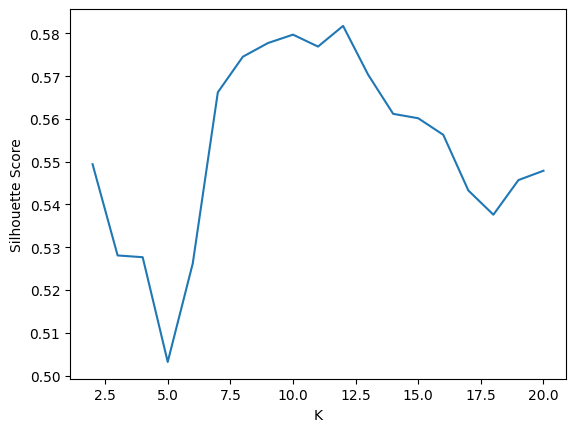

In [ ]:
# Visualize silhouette score
plt.plot(range(2,21),sil_score)
plt.xlabel('K')
plt.ylabel('Silhouette Score')

Based on the plot above, K=7 has silhoueete score greater than K=3. But, the max silhouette score is possessed by K=12. Despite of this confusing result, we have to analyze the results based on the visualization. Our business acument and wise be needed.

In [ ]:
# Create a function

def cluster_map_plot(k):
  km = KMeans(n_clusters=k).fit(X)
  scaler.inverse_transform(km.cluster_centers_)
  color_dict={0:'maroon',1:'red',2:'blue',3:'cyan',4:'black',5:'snow',6:'yellow',7:'palegreen',8:'teal',9:'orange',
              10:'slategrey',11:'hotpink'}
  fig,ax = plt.subplots(figsize=(16,8))
  map.plot(ax=ax)
  sns.scatterplot(x=df['longitude'],y=df['latitude'],hue=km.labels_,palette=color_dict)
  centers = scaler.inverse_transform(km.cluster_centers_)
  sns.scatterplot(x=centers[:,0],y=centers[:,1],s=500,marker='*')
  ax.set_xlim(-125,-65)
  ax.set_ylim(25,50)
  return centers

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


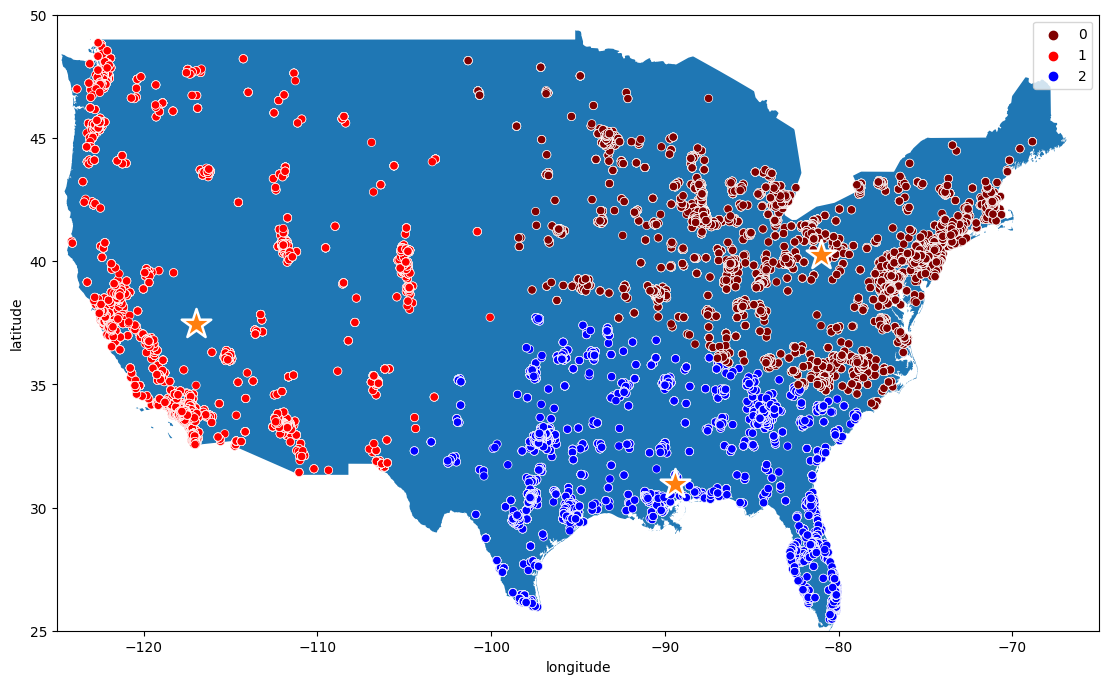

In [ ]:
# show 3 clusters
c3 = cluster_map_plot(3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


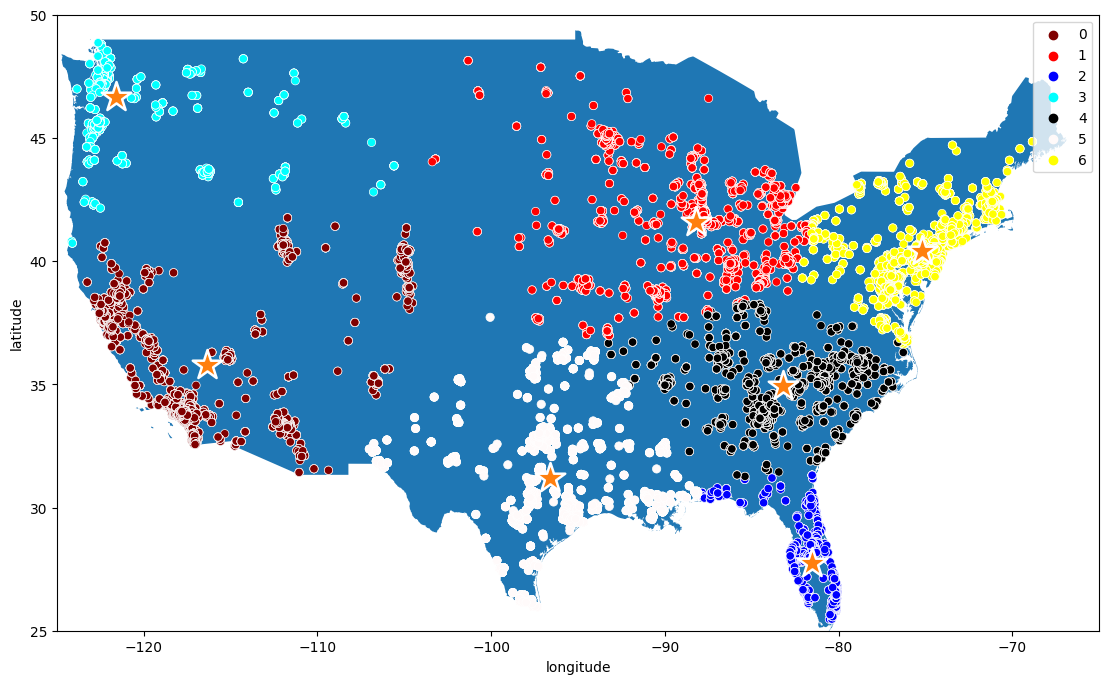

In [ ]:
# show 7 clusters
c7 = cluster_map_plot(7)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


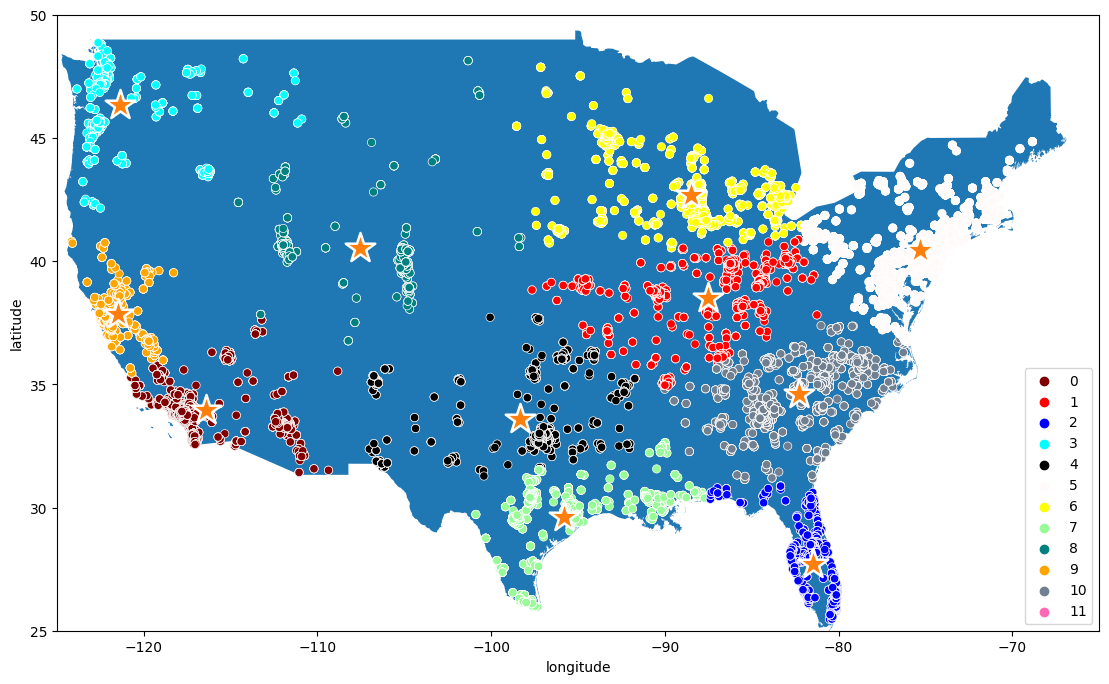

In [ ]:
# show 12 clusters
c12 = cluster_map_plot(12)

Based on tree maps above, we can conclude that in aims to fullfil our goal, build 3 wearehouses wont solve our problem. Meanwhile, build 7 and 12 warehouses will be a great consideration since these can catch more customers closely. But, we need to consider our budget.

For the step analysis(we dont discuss about this), we need to take account the financial and efficiency analysis including capital and operational cost, number of daily customers in thoses in thoses areas, and delivery time from each warehouse to the customers in the warehouse cluster.


In [ ]:
# Find excat location using geopy for 12 clusters scenario
geolocator = Nominatim(user_agent='abcd') # abcd is password and can be changed

In [ ]:
c12

array([[-116.42707306,   33.97689861],
       [ -87.49549762,   38.50973837],
       [ -81.49763628,   27.69025469],
       [-121.34902447,   46.32171894],
       [ -98.33038943,   33.5827831 ],
       [ -75.30875816,   40.47130886],
       [ -88.47826383,   42.70145935],
       [ -95.82633996,   29.61948656],
       [-107.55192992,   40.53840459],
       [-121.45948978,   37.85085371],
       [ -82.28352812,   34.59594469],
       [-147.57093482,   61.22311652]])

In [ ]:
# Create dataframe
c12_df = pd.DataFrame(c12,columns=['long','lat'])

# Finding excact location
c12_df['location'] = c12_df.apply(lambda x:geolocator.reverse('{},{}'.format(x[1],x[0])).raw['display_name'],axis=1)

# show location
c12_df

,long,lat,location
0,-116.427073,33.976899,"Riverside County, California, United States"
1,-87.495498,38.509738,"Knox County, Indiana, 47524, United States"
2,-81.497636,27.690255,"999, Old Avon Park Road, Neilson, Polk County,..."
3,-121.349024,46.321719,"Yakima County, Washington, United States"
4,-98.330389,33.582783,"Clay County, Texas, United States"
5,-75.308758,40.471309,"Meadow Road, Richland Township, Bucks County, ..."
6,-88.478264,42.701459,"Potter Road, Elkhorn, Town of Lafayette, Walwo..."
7,-95.826340,29.619487,"Beadle Lane, Fort Bend County, Texas, United S..."
8,-107.551930,40.538405,"Craig, Moffat County, Colorado, 81625, United ..."
9,-121.459490,37.850854,"San Joaquin County, California, United States"


In [ ]:
c7

array([[-116.35752246,   35.7685228 ],
       [ -88.22036151,   41.59646116],
       [ -81.53979362,   27.7377586 ],
       [-121.58088869,   46.6525072 ],
       [ -83.22584133,   34.91926473],
       [ -96.62095975,   31.20427694],
       [ -75.19526905,   40.41558509]])

In [ ]:
# Create dataframe
c7_df = pd.DataFrame(c7,columns=['long','lat'])

# Finding excact location
c7_df['location'] = c7_df.apply(lambda x:geolocator.reverse('{},{}'.format(x[1],x[0])).raw['display_name'],axis=1)

# show location
c7_df

,long,lat,location
0,-116.357522,35.768523,"Ibex Spring Road, San Bernardino County, Calif..."
1,-88.220362,41.596461,"Dupage River Trail, Plainfield, Will County, I..."
2,-81.539794,27.737759,"701, South Clinch Lake Boulevard, Sunset Shore..."
3,-121.580889,46.652507,"Forest Road 4612, Lewis County, Washington, 98..."
4,-83.225841,34.919265,"Willis Knob Horse Trail, Rabun County, Georgia..."
5,-96.620960,31.204277,"Robertson County, Texas, United States"
6,-75.195269,40.415585,"Bedminster Road, Irish Meeting House, Bedminst..."
